In [7]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
from collections import namedtuple

#from Plot_tools import *
from File_tools import *
from CAM_util import radar_colormap

import pickle

_nthreads = 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
    
# Read in precip and w data

in_dir  = "/work/wicker/Odin_scr/solo"
out_dir = "/work/wicker/Odin_scr/solo"
prefix  = {"solo": "squall_3km", "wrf": "squall_3km", "cm1": "squall_3km"}

allcape = ("C2000","C3500")
allshear = ("06", "12", "18")

solo = {}
cm1  = {}
wrf  = {}

for shear in allshear:
    for cape in allcape:
        
        label = "%s_%s" % (cape, shear)
        
        solo_file = str(os.path.join(in_dir, "%s_%s" % (prefix['solo'], label)))
        solo[label] = getobjdata(solo_file, filename='atmos_hifreq.nc', model_type='fv3_solo')
                
        wrf_file = str(os.path.join("/work/wicker/WRF/WRF/test/em_quarter_ss", "%s_%s" % (prefix['wrf'], label)))
        wrf[label] = getobjdata(wrf_file, model_type='wrf')
                
        cm1_file = str(os.path.join("/work/wicker/Odin_scr/cm1r20.3/run", "%s_%s" % (prefix['cm1'], label)))
        cm1[label] = getobjdata(cm1_file, model_type='cm1')
        
with open('solo_%s_obj_profiles.pkl' % prefix['solo'], 'wb') as handle:
    pickle.dump(solo, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('wrf_%s_obj_profiles.pkl' % prefix['wrf'], 'wb') as handle:
    pickle.dump(wrf, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('cm1_%s_obj_profiles.pkl' % prefix['cm1'], 'wb') as handle:
    pickle.dump(cm1, handle, protocol=pickle.HIGHEST_PROTOCOL)



processing model run:  /work/wicker/Odin_scr/solo/squall_3km_C2000_06 

Reading:  /work/wicker/Odin_scr/solo/squall_3km_C2000_06/atmos_hifreq.nc 
processing model run:  /work/wicker/WRF/WRF/test/em_quarter_ss/squall_3km_C2000_06 

Reading:  /work/wicker/WRF/WRF/test/em_quarter_ss/squall_3km_C2000_06/wrfout_d01_0001-01-01_00:00:00 

Reading external DBZ file: /work/wicker/WRF/WRF/test/em_quarter_ss/squall_3km_C2000_06/wrf_dbz.npy

Shape of DBZ array:  (25, 60, 255, 255)
processing model run:  /work/wicker/Odin_scr/cm1r20.3/run/squall_3km_C2000_06 

Reading:  /work/wicker/Odin_scr/cm1r20.3/run/squall_3km_C2000_06/cm1out.nc 

Reading existing DBZ file in directory
processing model run:  /work/wicker/Odin_scr/solo/squall_3km_C3500_06 

Reading:  /work/wicker/Odin_scr/solo/squall_3km_C3500_06/atmos_hifreq.nc 
processing model run:  /work/wicker/WRF/WRF/test/em_quarter_ss/squall_3km_C3500_06 

Reading:  /work/wicker/WRF/WRF/test/em_quarter_ss/squall_3km_C3500_06/wrfout_d01_0001-01-01_00:00:0

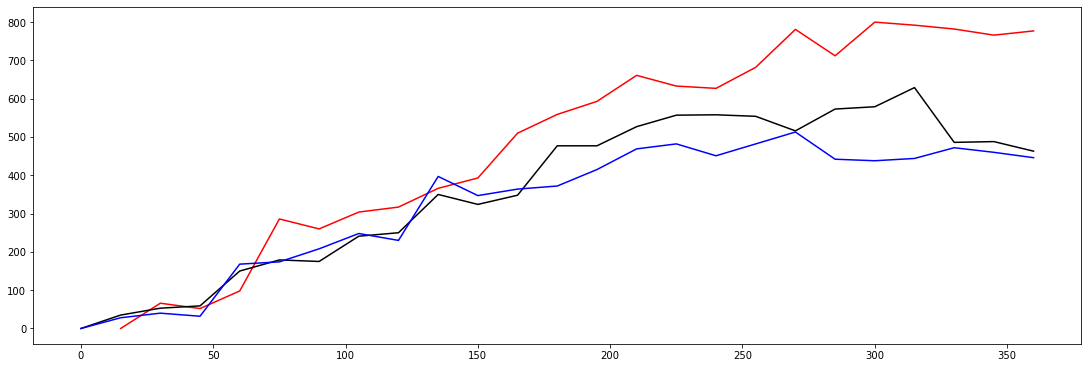

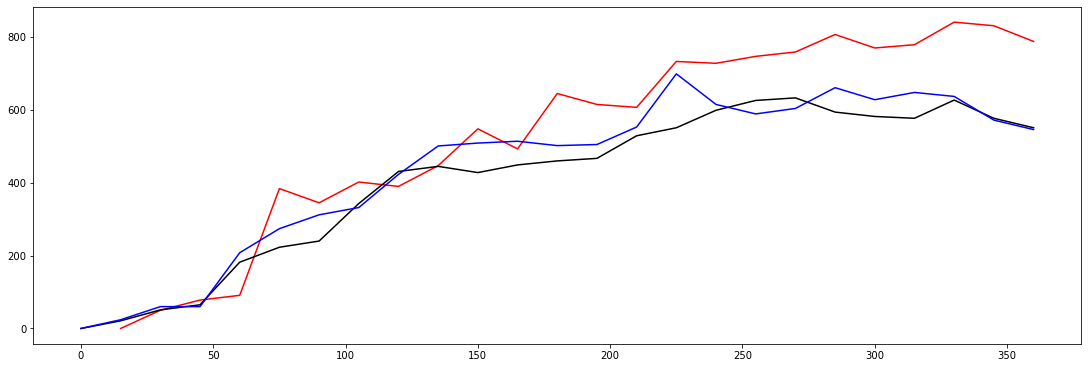

In [4]:
def countobj(data, label, cref_thresh = 35., w_thresh=5.):
    
    DBZ  = data[label]['dbz']
    W    = data[label]['w']
    PRES = data[label]['pres']

    ntimes = DBZ.shape[0]
    fcount = []
    
    for n in np.arange(ntimes):
        mask_cref   = np.where(DBZ[n].max(axis=0) > cref_thresh, True, False)
        mask_w_3d   = np.where(PRES[n] < 70000.0, W[n], np.nan)

        mask_w_2d   = np.nanmax(mask_w_3d, axis=0)
        mask_w_cref = (mask_w_2d > w_thresh) & mask_cref
        f_mask      = mask_w_cref.astype(np.int8)
    
        fcount.append(np.sum(f_mask > 0))
        
    return fcount

#-----------------------------
allcape = ("C3500",)
allshear = ("06","18")

for shear in allshear:
    for cape in allcape:

        fig, ax = plt.subplots(1,1, constrained_layout=True,figsize=(15,5))
        
        label = "%s_%s" % (cape, shear)
        
        scount = countobj(solo, label)
        wcount = countobj(wrf, label)
        ccount = countobj(cm1, label)
        
        ntimes = 15+15*np.arange(len(scount))
        
        ax.plot(ntimes, scount, color='r', label='FV3_SOLO')
        
        ntimes = 15*np.arange(len(wcount))

        ax.plot(ntimes, wcount, color='k', label='WRF')
        ax.plot(ntimes, ccount, color='b', label='CM1')
        
        plt.show()


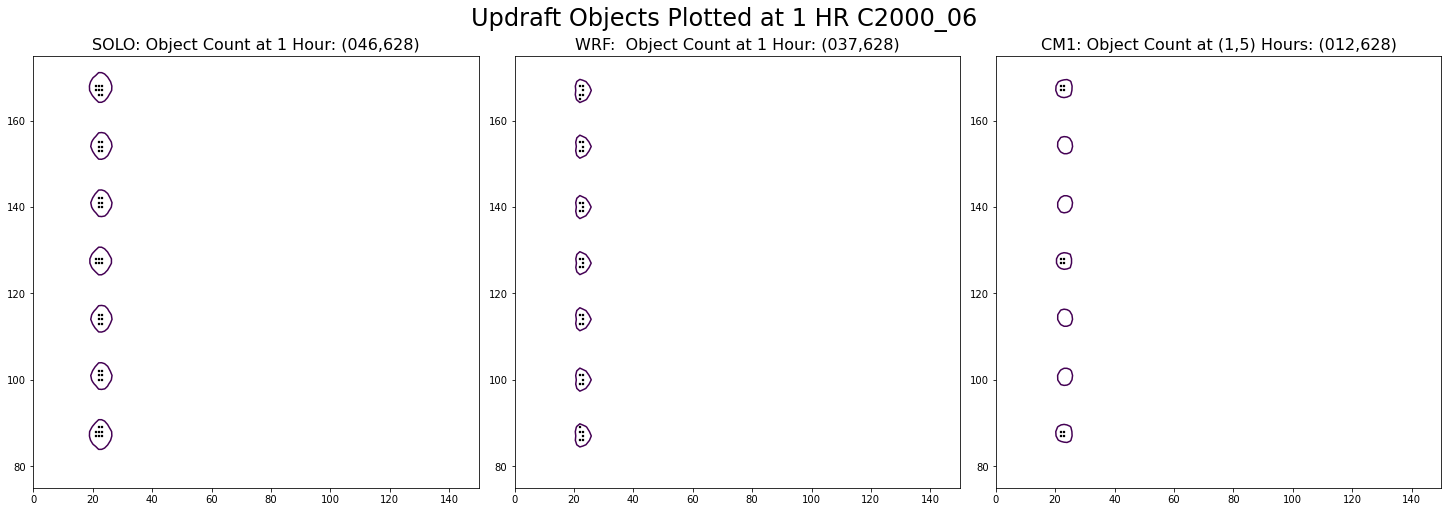

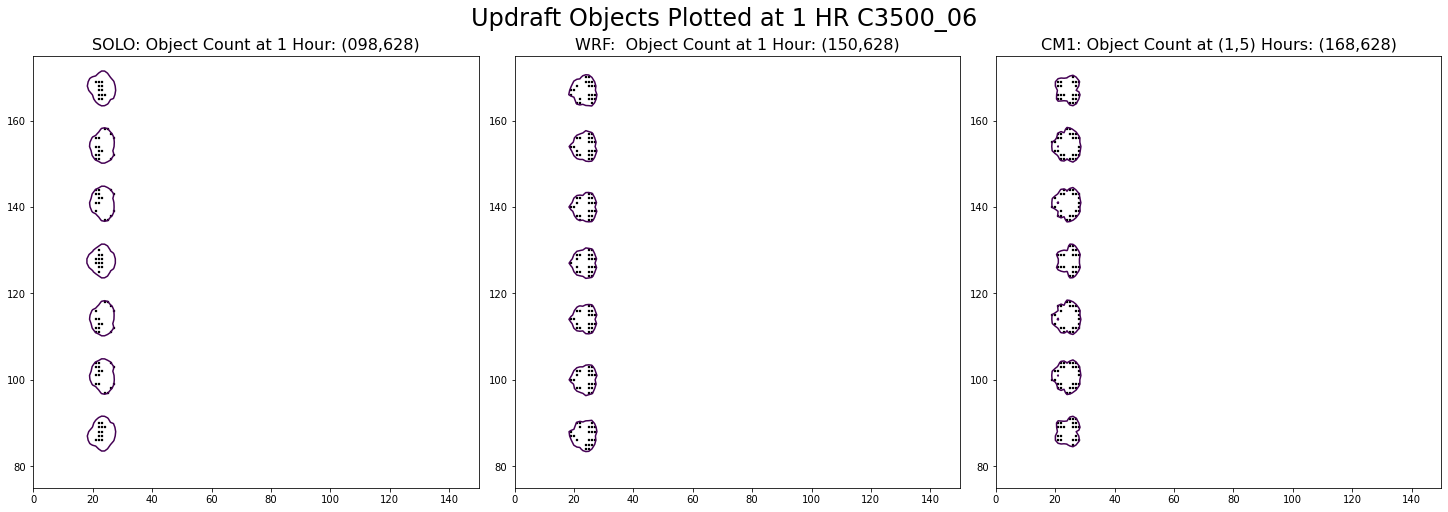

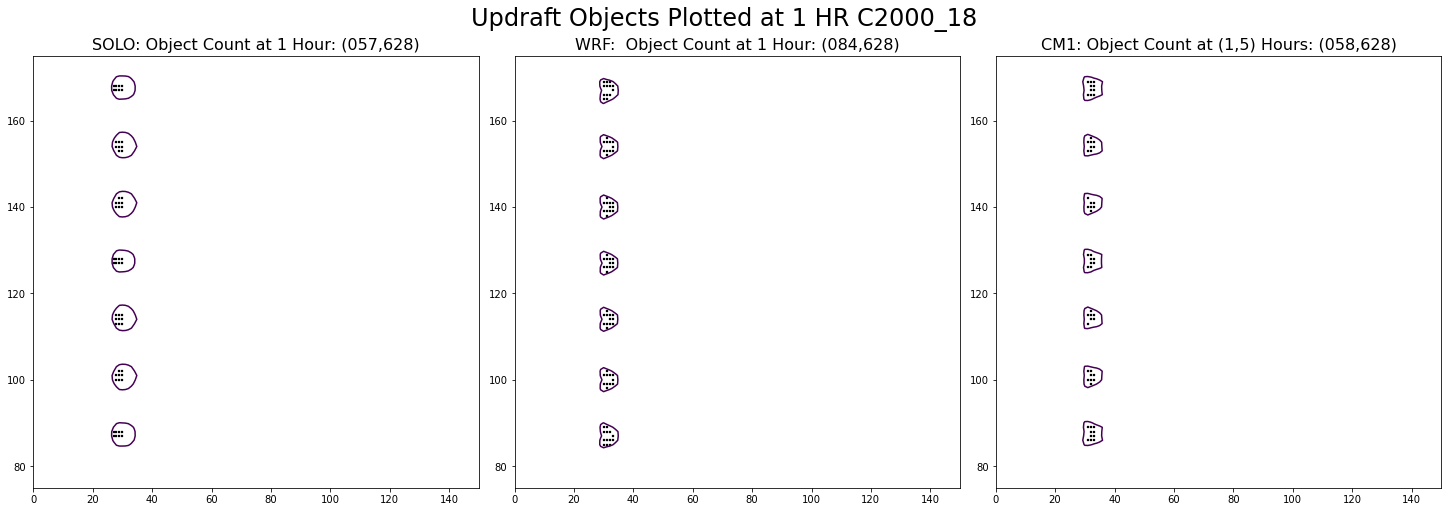

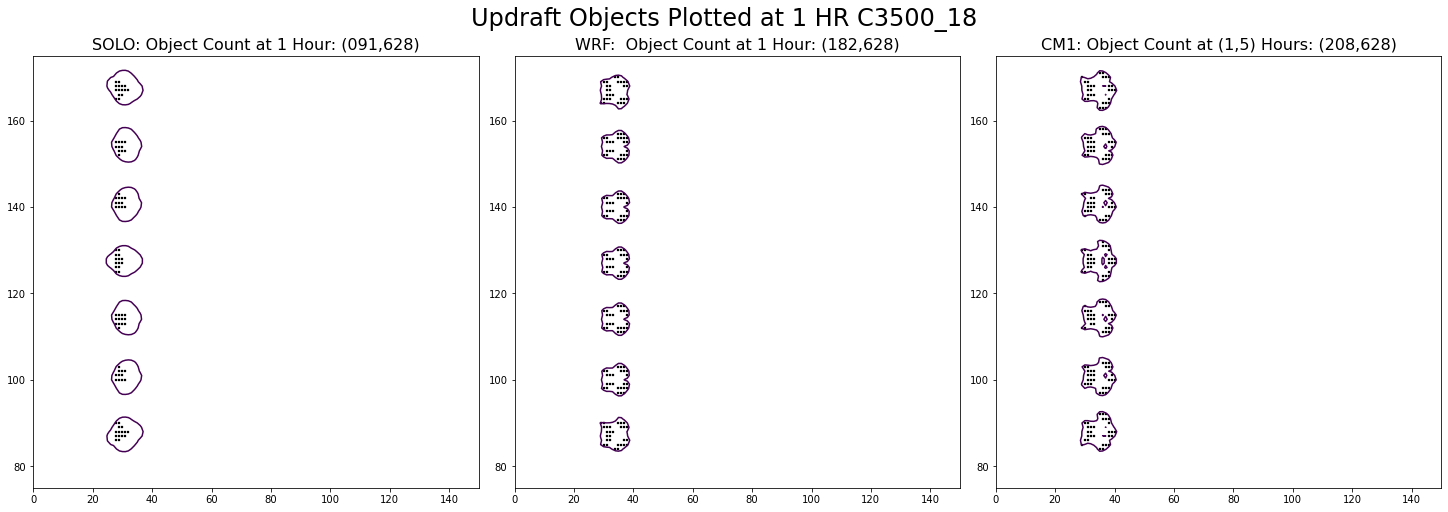

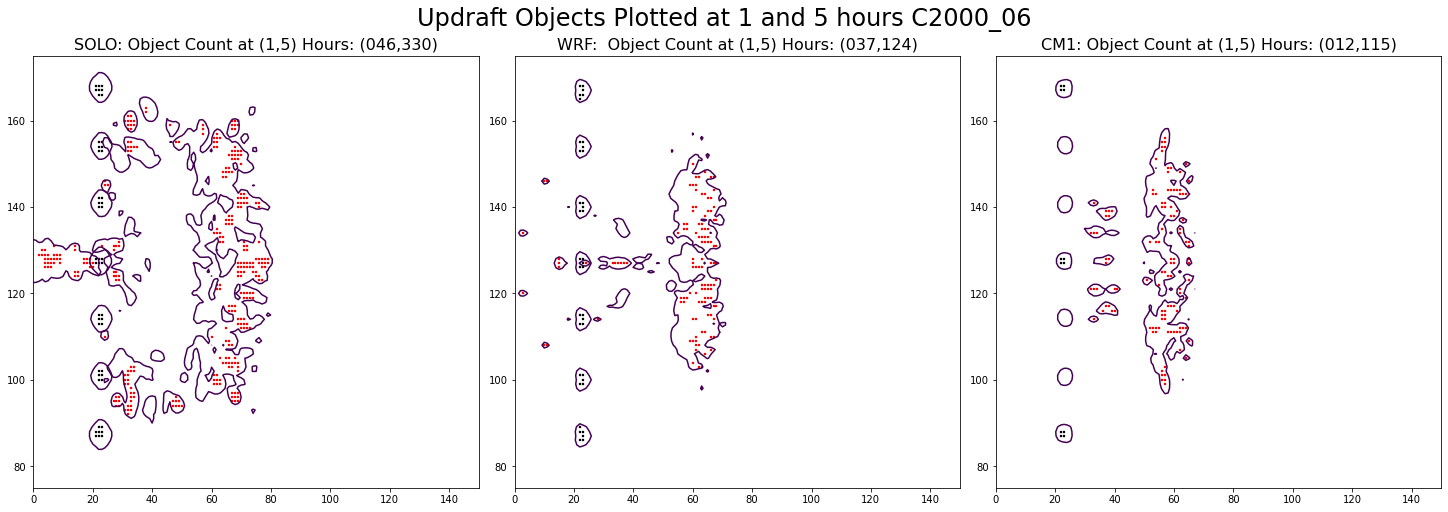

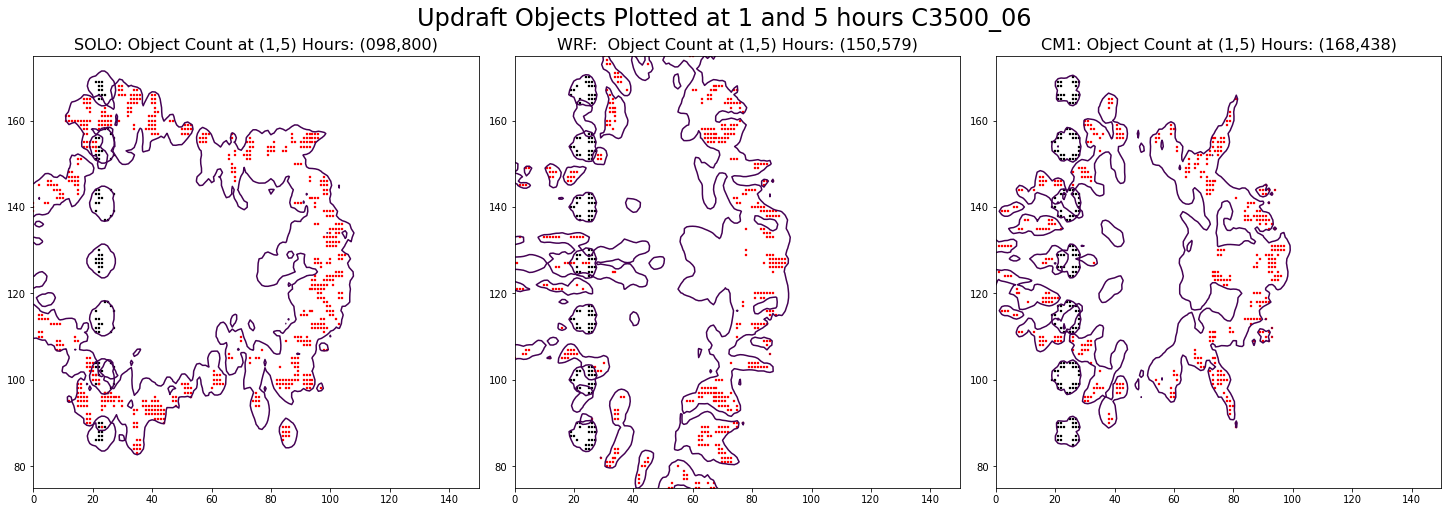

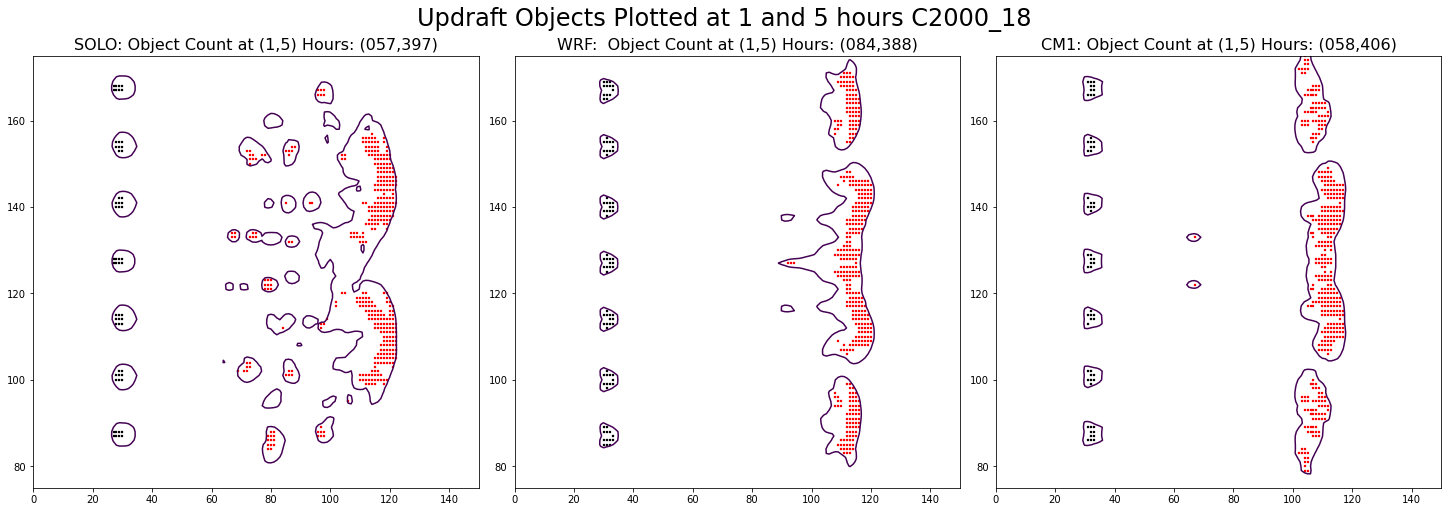

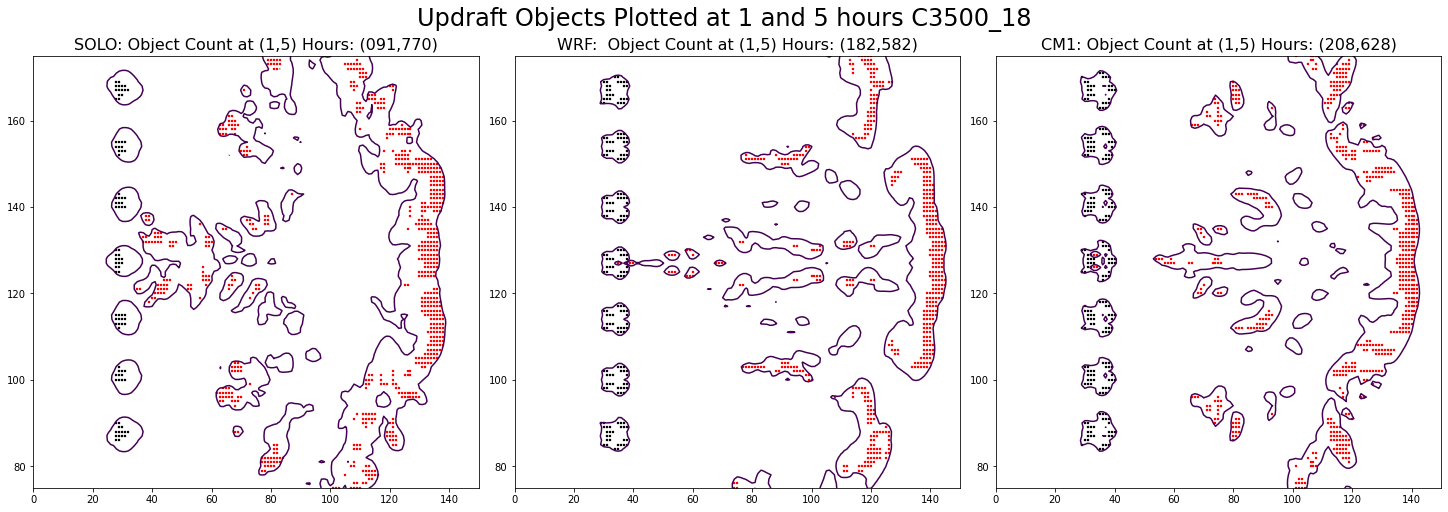

In [29]:
# Just read stuff back in...
            
def plotobj(data, label, time = 8, ax = None, colors='k', alpha=1.0, cref_thresh = 35., marker="s", w_thresh=5.):
    
    DBZ  = data[label]['dbz'][time]
    W    = data[label]['w'][time]
    PRES = data[label]['pres'][time]
        
    mask_cref   = np.where(DBZ.max(axis=0) > cref_thresh, True, False)
    mask_w_3d   = np.where(PRES < 70000.0, W, np.nan)

    mask_w_2d   = np.nanmax(mask_w_3d, axis=0)
    mask_w_cref = (mask_w_2d > w_thresh) & mask_cref
    f_mask      = mask_w_cref.astype(np.int8)
    
    ctable = radar_colormap()
    levels = [5 + 5*n for n in range(15)]
    
    x = np.arange(DBZ.shape[1])
    y = np.arange(DBZ.shape[2])
    xx, yy = np.meshgrid(x,y)
    
    ax.contour(DBZ.max(axis=0), levels=[35], color='black')
    ax.scatter(xx[f_mask>0], yy[f_mask>0], s=4, c=colors, marker=marker, alpha=alpha, linewidths=0.25)
    
    ax.set_ylim(75., 175.)
    ax.set_xlim(0., 150.)
    
    return np.sum(f_mask > 0)

#-----------------------------
allcape = ("C2000","C3500")
allshear = ("06","18")

for shear in allshear:
    for cape in allcape:

        fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,7))
        
        label = "%s_%s" % (cape, shear)
        
        o1 = plotobj(solo, label, ax = ax[0], time=3, colors='k', marker="s")
        
        ax[0].set_title("SOLO: Object Count at 1 Hour: (%3.3d,%3.3d)" % (o1, o4), fontsize=16)
        
        o1 = plotobj(wrf, label, ax = ax[1], time=4, colors='k', marker="s")
        
        ax[1].set_title("WRF:  Object Count at 1 Hour: (%3.3d,%3.3d)" % (o1, o4), fontsize=16)

        o1 = plotobj(cm1, label, ax = ax[2], time=4, colors='k', marker="s")
        
        ax[2].set_title("CM1: Object Count at (1,5) Hours: (%3.3d,%3.3d)" % (o1, o4), fontsize=16)

        plt.suptitle("%s %s" % ("Updraft Objects Plotted at 1 HR", label), fontsize=24)
        
        plt.show()

for shear in allshear:
    for cape in allcape:

        fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,7))
        
        label = "%s_%s" % (cape, shear)
        
        o1 = plotobj(solo, label, ax = ax[0], time=3, colors='k', marker="s")
        o4 = plotobj(solo, label, ax = ax[0], time=19, colors='r', marker="s", alpha=1)
        
        ax[0].set_title("SOLO: Object Count at (1,5) Hours: (%3.3d,%3.3d)" % (o1, o4), fontsize=16)
        
        o1 = plotobj(wrf, label, ax = ax[1], time=4, colors='k', marker="s")
        o4 = plotobj(wrf, label, ax = ax[1], time=20, colors='r', marker="s", alpha=1)
        
        ax[1].set_title("WRF:  Object Count at (1,5) Hours: (%3.3d,%3.3d)" % (o1, o4), fontsize=16)

        o1 = plotobj(cm1, label, ax = ax[2], time=4, colors='k', marker="s")
        o4 = plotobj(cm1, label, ax = ax[2], time=20, colors='r', marker="s", alpha=1)
        
        ax[2].set_title("CM1: Object Count at (1,5) Hours: (%3.3d,%3.3d)" % (o1, o4), fontsize=16)

        plt.suptitle("%s %s" % ("Updraft Objects Plotted at 1 and 5 hours", label), fontsize=24)
        
        plt.show()